the main question was if:

On the population:
 - (1) the dimensionality really changes over session?
 - (2) if it does, isn't it an artefact of TOT effect?
- (3) can it be explained by any behavioral variables?

on the single unit level:
- somehow relate CV or LvR to D?

In [1]:
# imports
import sys
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# plot venn diagram of the significant units of model 'no cmw short history' and 'cmw short history'

from popy.io_tools import load_metadata, load_neural_data, load_behavior
from popy.neural_data_tools import *
from popy.behavior_data_tools import *
from popy.plotting.plotting_tools import plot_keypoints
from popy.plotting.plot_behavior import show_target_selection

import popy.config as cfg

# get dimensionality of session
def cv_explains_dim(cvs, dims_mcc, dims_lpfc):
    # regress dims with cv

    # cross validate
    reg_mcc = LinearRegression()
    score_mcc = cross_val_score(reg_mcc, cvs, dims_mcc, cv=10).mean()

    # cross validate
    reg_lpfc = LinearRegression()
    score_lpfc = cross_val_score(reg_lpfc, cvs, dims_lpfc, cv=10).mean()

    return score_mcc, score_lpfc

def get_dimensionality(X):
    X = X.T  # samples x features
    
    # normalize the data (z-score)
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    pca = PCA()  # do pca
    pca.fit(X)
    
    eigenvalues = pca.explained_variance_
    numerator = np.sum(eigenvalues) ** 2
    denominator = np.sum(eigenvalues ** 2)
    return numerator/denominator  #dimensionality (edited) 

# plot change of dimensionality over 40 trial sliding window

def measure_dimensionality(neural_data, wil_len=40, skip_len=1, do_cvs=True):
    trial_ids = np.unique(neural_data.trial_id)
    n_trials = len(trial_ids)

    dims_mcc = []
    dims_lpfc = []
    cvs = []
    for i in range(0, n_trials-wil_len, skip_len):
        trial_id = trial_ids[i]
        
        trials = np.arange(trial_id, trial_id + wil_len)
        neural_data_temp = neural_data.sel(time=neural_data.trial_id.isin(trials))
        if do_cvs:
            neural_data_temp = add_CV(neural_data_temp, epochs='full_only')
        neural_data_temp = neural_data_temp.firing_rates

        dims_mcc.append(get_dimensionality(neural_data_temp.sel(unit=neural_data_temp.unit[neural_data_temp.area == 'MCC']).values))
        dims_lpfc.append(get_dimensionality(neural_data_temp.sel(unit=neural_data_temp.unit[neural_data_temp.area == 'LPFC']).values))
        
        if do_cvs:
            cvs.append(neural_data_temp.CV_full.values)

    dims_mcc = np.array(dims_mcc)
    dims_lpfc = np.array(dims_lpfc)
    cvs = np.array(cvs)

    return dims_mcc, dims_lpfc, cvs

In [2]:
# data loading and processing
session_metadata = load_metadata()
session_metadata = session_metadata[session_metadata['block_len_valid'] == True]

monkey, session = 'ka', '210322'

neural_data = load_neural_data(monkey, session, return_dataset_format=True)
neural_data = add_firing_rates(neural_data)

# cleaning the data
user_msg = True
neural_data = remove_trunctuated_neurons(neural_data, print_usr_msg=user_msg, mode='remove', delay_limit=10)
#neural_data = remove_low_fr_neurons(neural_data, print_usr_msg=user_msg)
#neural_data = remove_low_varance_neurons(neural_data, print_usr_msg=user_msg, var_limit=1)
#neural_data = remove_drift_neurons(neural_data, print_usr_msg=user_msg)

# add cv
#neural_data = add_CV(neural_data, epochs='full_only')

'''behav = load_behavior(monkey, session)
behav = add_reaction_time(behav)
behav = drop_time_fields(behav)
behav = add_phase_info(behav, numeric=True)
show_target_selection(behav)'''

dims_mcc, dims_lpfc, cvs = measure_dimensionality(neural_data, wil_len=2, skip_len=2, do_cvs=False)
#score_mcc, score_lpfc = cv_explains_dim(cvs, dims_mcc, dims_lpfc)
#print('MCC:', score_mcc, 'LPFC:', score_lpfc)
        

Removed 12/47 units with trunctuated recordings, delay limit: 10 s.


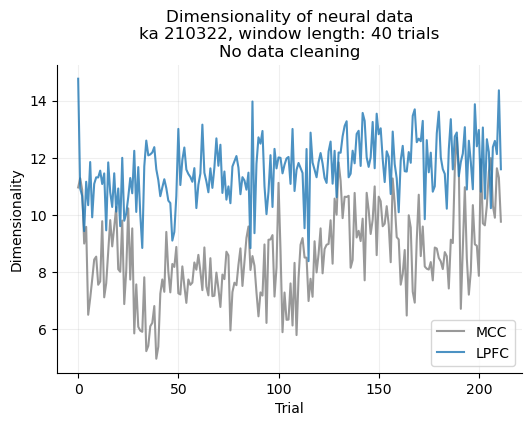

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(dims_mcc, label='MCC', color='gray', alpha=0.8)
ax.plot(dims_lpfc, label='LPFC', color='tab:blue', alpha=0.8)
ax.set_xlabel('Trial')
ax.set_ylabel('Dimensionality')
ax.set_title(f'Dimensionality of neural data\n{monkey} {session}, window length: 40 trials\nNo data cleaning')
ax.legend()
ax.grid(alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [4]:
cv_explains_dim(cvs, dims_mcc, dims_lpfc)

ValueError: Found input variables with inconsistent numbers of samples: [0, 212]